# pySCENIC protocol: PBMC10k

September 2019

Dataset: *10k PBMCs from a Healthy Donor* available from 10x Genomics ([here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3)).

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import umap
from MulticoreTSNE import MulticoreTSNE as TSNE

import glob
import json
import zlib
import base64

import seaborn as sns
import matplotlib.pyplot as plt

/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ddir = "/scr/qlyu/projects/v1/data/jain22_nature_flybrain"
outdir = "/scr/qlyu/projects/v1/data/jain22_nature_flybrain/res"

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
sc.settings.njobs = 4 # 20

In [4]:
# # data
# f_mtx_dir = '/scr/qlyu/projects/v1/data/10x_pbmc/filtered_feature_bc_matrix'

# # transcription factors list
# f_tfs = "/scr/qlyu/projects/v1/data/annot/allTFs_hg38.txt"

# # ranking databases
# f_db_glob = "/scr/qlyu/projects/v1/data/annot/hg38*feather"
# f_db_names = ' '.join(glob.glob(f_db_glob))

# # motif databases
# f_motif_path = "/scr/qlyu/projects/v1/data/annot/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [5]:
f_adata = os.path.join(ddir, "scEcRDN.h5ad")

# path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom = os.path.join(outdir, "scEcRDN.loom")

# # path to pyscenic output
# f_pyscenic_output = os.path.join(outdir, "pyscenic_output.loom")

# # loom output, generated from a combination of Scanpy and pySCENIC results:
# f_final_loom = os.path.join(outdir, 'pbmc10k_scenic_integrated-output.loom')

# # adj output
# f_adj = os.path.join(outdir, "adj.csv")
# # reg output
# f_reg = os.path.join(outdir, "reg.csv")

# # umap and tsne output
# f_umap = os.path.join(outdir, "scenic_umap.txt") 
# f_tsne = os.path.join(outdir, "scenic_tsne.txt")

### Reading in expression data: 10x Genomics mtx files

In [6]:
%%time
adata = sc.read(f_adata)
adata
# adata = sc.read_10x_mtx(
#     f_mtx_dir ,                 # the directory with the `.mtx` file
#     var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
#     cache=False) 

CPU times: user 767 ms, sys: 71.5 ms, total: 839 ms
Wall time: 838 ms


AnnData object with n_obs × n_vars = 5082 × 17562
    obs: 'replicate', 'genotype', 'time', 'condition', 'celltype', 'cell_condition', 'time_condition', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [7]:
adata.X = adata.raw.X

### Initial/basic filtering

In [8]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
minSamples=.01*nCells # 1% of cells

# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)

# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')

# total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / adata.obs['n_counts']

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())
print("minCountsPerGene: ", minCountsPerGene)
print("minSamples: ", minSamples)

Number of counts (in the dataset units) per gene: 0.0  -  1263250.0
Number of cells in which each gene is detected: 0  -  5082
minCountsPerGene:  152.46
minSamples:  50.82


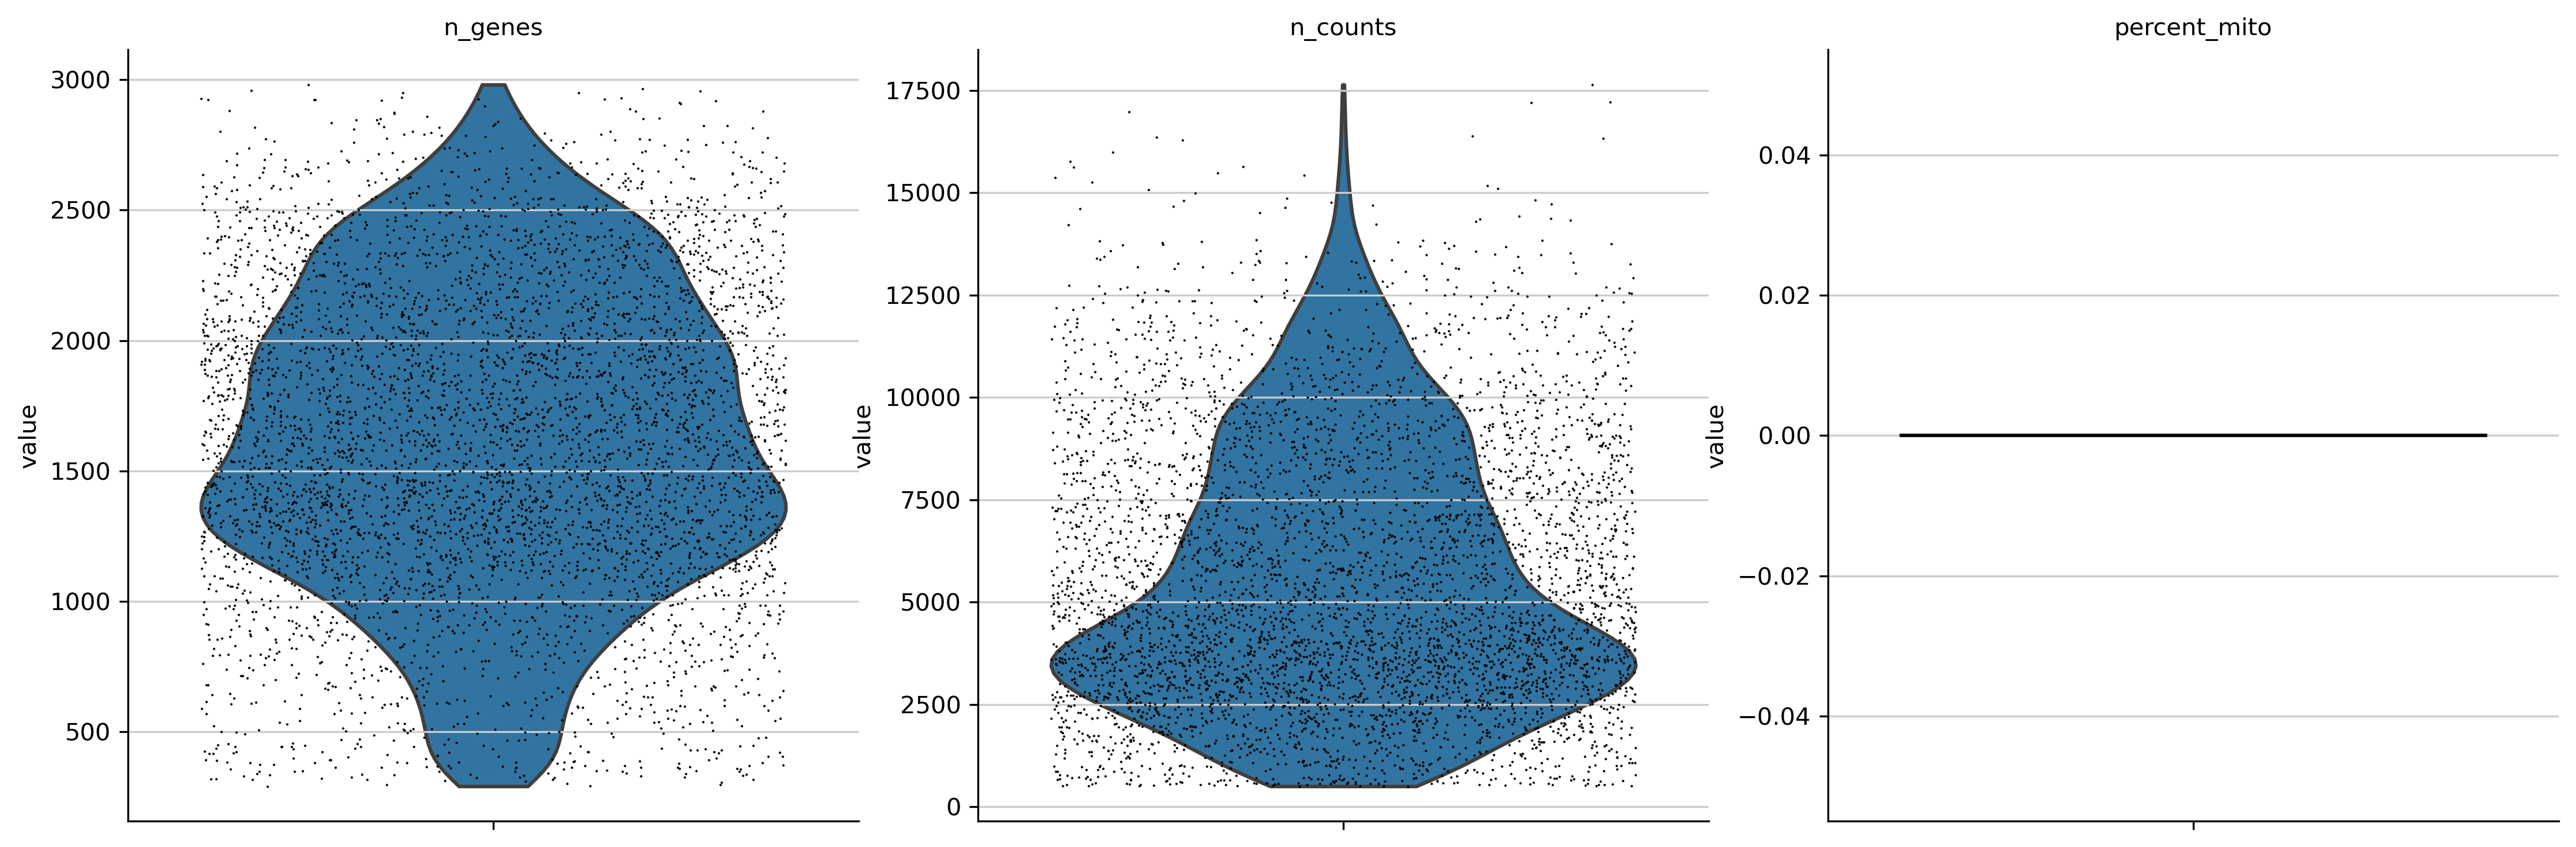

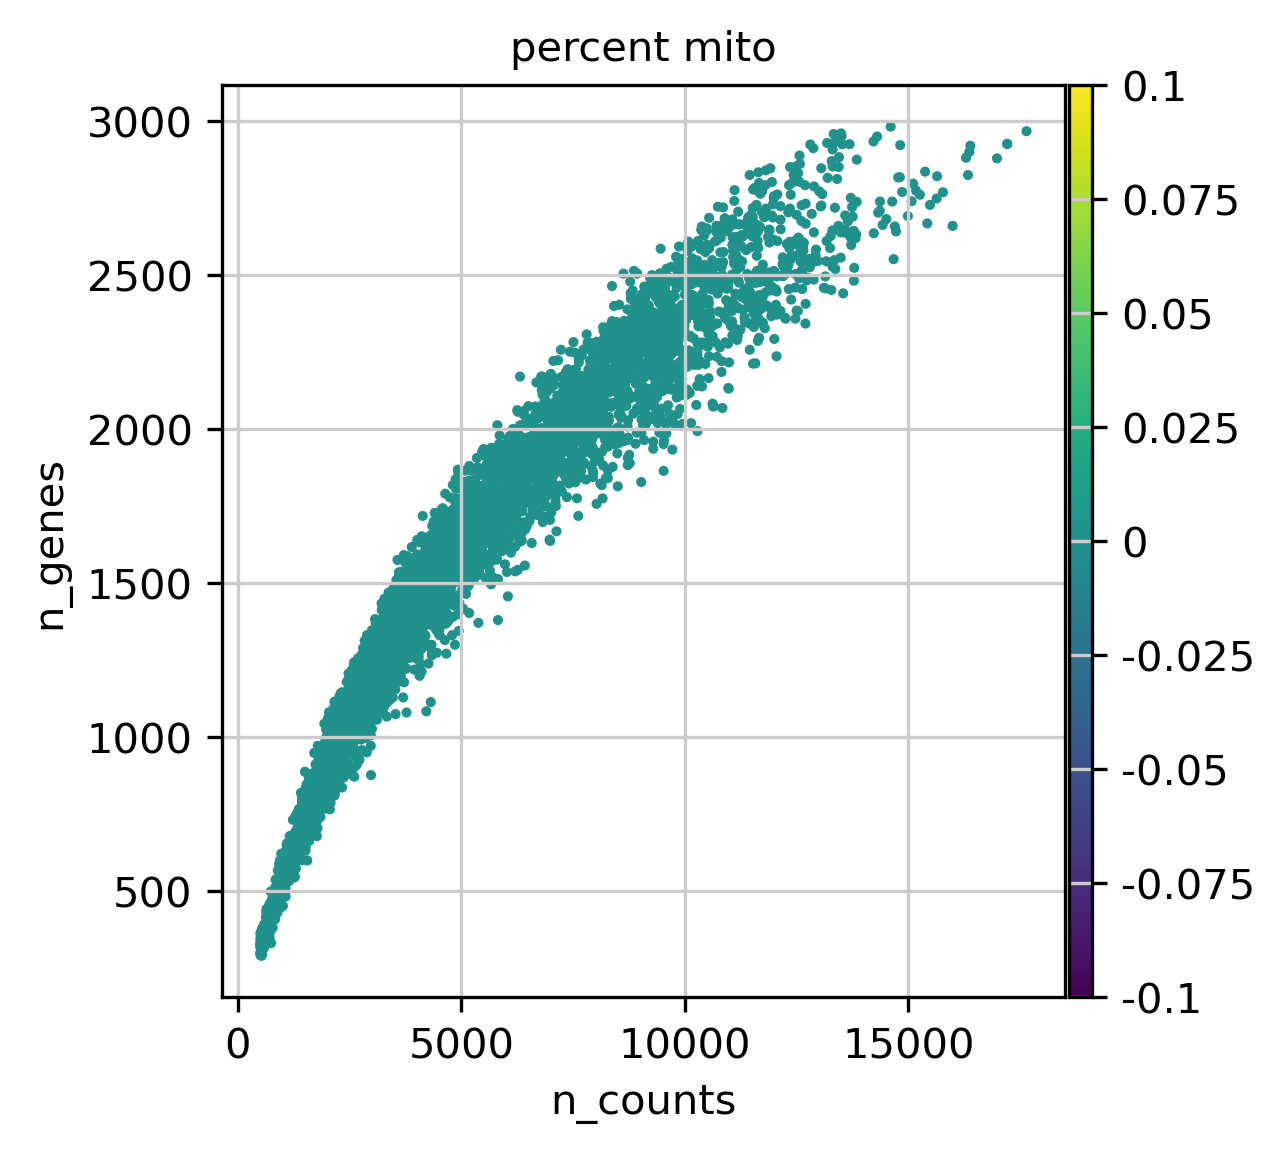

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True )
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [10]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# cuts
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

filtered out 7664 genes that are detected in less than 3 cells


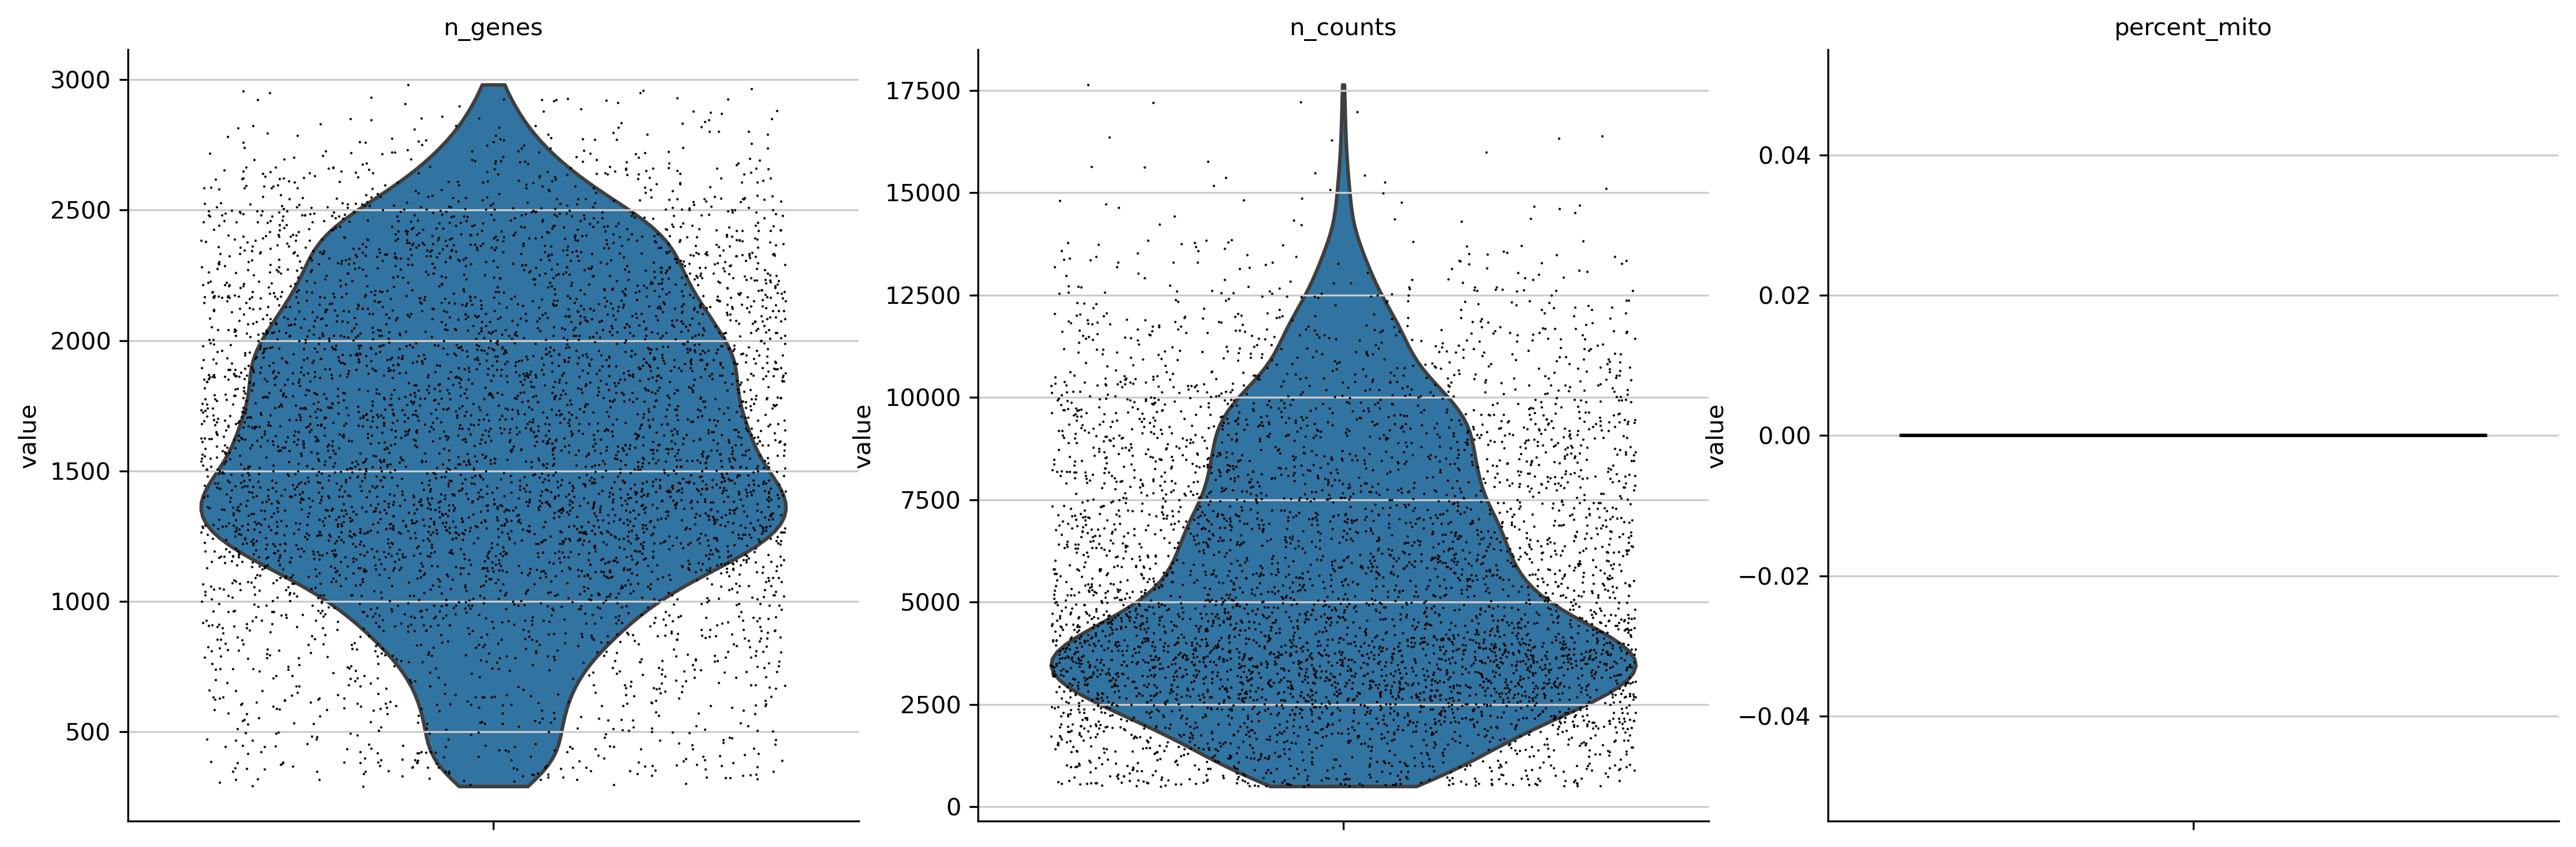

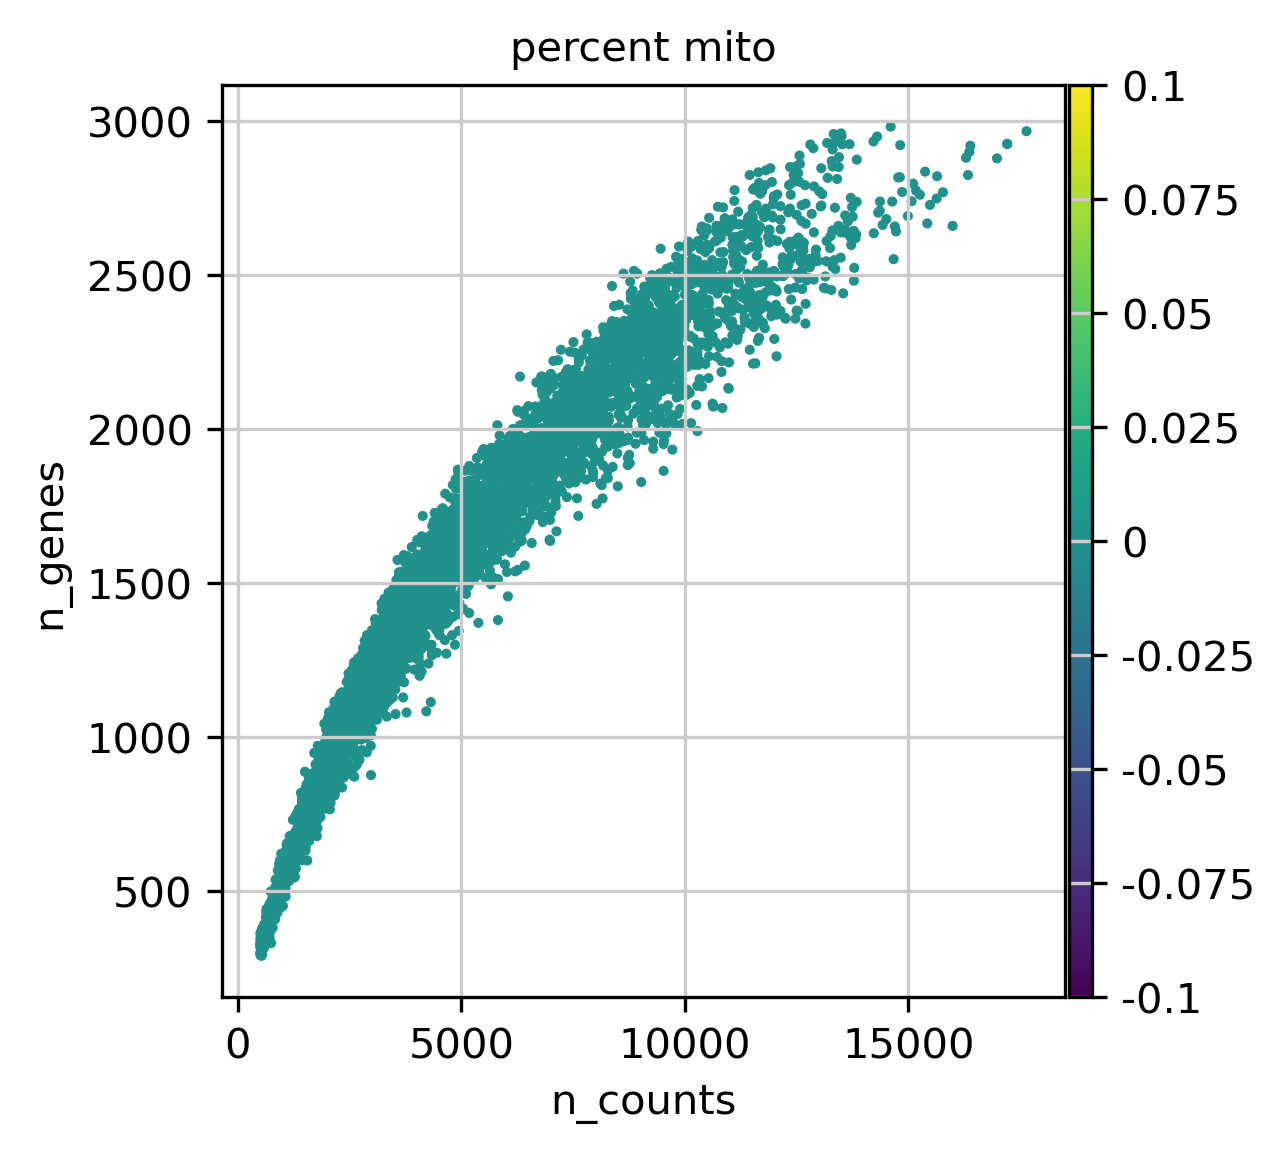

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True )
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [12]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene"  : np.array(adata.var_names),
}
col_attrs = {
    "CellID": np.array(adata.obs_names),
    "nGene" : np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(),
    "nUMI"  : np.array(np.sum(adata.X.transpose()  , axis=0)).flatten(),
}
lp.create(f_loom, adata.X.transpose(), row_attrs, col_attrs)

## SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules
#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

locations for ranking databases, and motif annotations:

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **1192** genes are selected for the rankings based on the plot below.

In [ ]:
%%time
# 4 hrs
# !pyscenic grn {f_loom_path_scenic} {f_tfs} -o {f_adj} --num_workers 1

In [ ]:
%%time 
# ~0.5 hr
# !pyscenic ctx {f_adj} \
#     {f_db_names} \
#     --annotations_fname {f_motif_path} \
#     --expression_mtx_fname {f_loom_path_scenic} \
#     --output {f_reg} \
#     --mask_dropouts \
#     --num_workers 2

In [ ]:
%%time 
# 10 min
# !pyscenic aucell \
#     {f_loom_path_scenic} \
#     {f_reg} \
#     --output {f_pyscenic_output} \
#     --num_workers 2

### Visualization of SCENIC's AUC matrix

In [ ]:
nGenesDetectedPerCell = np.ravel(np.sum(adata.X>0, axis=1))
percentiles = pd.Series(nGenesDetectedPerCell).quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

First, load the relevant data from the loom we just created

In [ ]:
# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
# UMAP
dr_umap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform(auc_mtx)
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv(f_umap, sep='\t')
# tSNE
dr_tsne = TSNE(n_jobs=2).fit_transform(auc_mtx)
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv(f_tsne, sep='\t')

## Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv(f_umap, sep='\t', header=0, index_col=0)
dr_tsne = pd.read_csv(f_tsne, sep='\t', header=0, index_col=0)
###

Fix regulon objects to display properly in SCope:

In [ ]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [ ]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0],
        pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.index)[0],
        dr_tsne['X'],
        dr_umap['X'],
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1],
        pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.index)[1],
        dr_tsne['Y'],
        dr_umap['Y'],
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [ ]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy leiden default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Leiden_clusters_Scanpy",
        "values": list(set( adata.obs['leiden'].astype(np.str) ))
    },
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['leiden']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['leiden'].values.astype(np.int64)

Assemble loom file row and column attributes

In [ ]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [ ]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Leiden_clusters_Scanpy": np.array( adata.obs['leiden'].values ),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['leiden'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

Create a new loom file, copying the expression matrix from the open loom connection:

In [ ]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file